# Detección de spam con Deep Learning (DL)

Este cuaderno demuestra el proceso de construcción y evaluación de múltiples modelos de redes neuronales para la detección de spam. El conjunto de datos se preprocesa, se vectoriza y luego se utiliza para entrenar y evaluar diferentes modelos de DL.

---

## 1. Importación de librerías

El código comienza importando las librerías necesarias para el procesamiento de datos, el modelo de red neuronal y la evaluación.

In [32]:
import tratarDatosSimple
import os
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics

# Carga y división de datos
xtrain, xtest, ytrain, ytest = tratarDatosSimple.combinar_y_dividir_datos()

---

## 2. Tokenización y Preprocesamiento

El texto se convierte en secuencias numéricas y se rellenan para tener una longitud fija.

In [33]:
# Tokenización
tokenizer = Tokenizer()
tokenizer.fit_on_texts(xtrain)

# Conversión a secuencias
train_secuencia = tokenizer.texts_to_sequences(xtrain)
test_secuencia = tokenizer.texts_to_sequences(xtest)

# Optimización de longitud de secuencia
max_len = 100   # Longitud máxima fija
x_train = pad_sequences(train_secuencia, maxlen=max_len, truncating="post")
x_test = pad_sequences(test_secuencia, maxlen=max_len, truncating="post")

# Conversión a arrays de numpy
y_train = np.array(ytrain, dtype=np.float16)
y_test = np.array(ytest, dtype=np.float16)  # Convertir a float16 para ahorrar RAM

# Conversión a tensores de PyTorch
x_train = torch.tensor(x_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float16)
X_val = torch.tensor(x_test, dtype=torch.long)
y_val = torch.tensor(y_test, dtype=torch.float16)

# Creación de DataLoaders
batch_size = 32
train_data = TensorDataset(x_train, y_train)
val_data = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, pin_memory=True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, pin_memory=True)

---

## 3. Definición de Modelos

Se definen tres arquitecturas de modelos: LSTM, RNN y MLP.

In [34]:
# Modelo LSTM
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=128, output_size=1, n_layers=2, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.lstm(embedded)
        out = self.dropout(out[:, -1])
        out = self.fc(out)
        return out

# Modelo RNN
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=128, output_size=1, n_layers=2, drop_prob=0.5):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        out, _ = self.rnn(embedded)
        out = self.dropout(out)
        out = self.fc(out[:, -1])
        return out

# Modelo MLP
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=128, output_size=1, n_layers=2, drop_prob=0.5):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * max_len, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_size)
        self.dropout = nn.Dropout(drop_prob)
        self.relu = nn.ReLU()

    def forward(self, x):
        embedded = self.embedding(x)  

        embedded = embedded.view(embedded.size(0), -1)

        out = self.fc1(embedded)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        return out


---

## 4. Configuración y Entrenamiento

Se configuran los modelos, optimizadores y funciones de pérdida.

In [35]:
# Función de precisión
def precision(outputs, labels):
    probs = torch.sigmoid(outputs)  # Convertir logits a probabilidades
    preds = (probs > 0.5).float()  # Convertir probabilidades a predicción binaria
    return (preds == labels).float().mean()  # calcular precisión

# Configuración del modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200 
hidden_dim = 128
output_size = 1
n_layers = 2
epochs = 10

# Inicialización de modelos
lstm_modelo = LSTM(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)
lstm_optimizador = optim.Adam(lstm_modelo.parameters(), lr=0.001)

rnn_modelo = RNN(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)
rnn_optimizador = optim.Adam(rnn_modelo.parameters(), lr=0.001)

mlp_modelo = MLP(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)
mlp_optimizador = optim.Adam(mlp_modelo.parameters(), lr=0.001)

# Función de pérdida
func_perdida = nn.BCEWithLogitsLoss()

---

## 5. Entrenamiento y Evaluación

Se definen las funciones de entrenamiento y evaluación de cada modelo, mostrando métricas como precisión, matriz de confusión y curva ROC.

In [36]:
# Crear la carpeta resultados/ML si no existe
os.makedirs("resultados/DL", exist_ok=True)

# Función para entrenar y validar
def entrenamineto_y_validacion(modelo, optimizador, func_perdida, train_loader, val_loader, epochs, device):
    train_perdidas, val_perdidas, val_accs = [], [], []
    for epoch in range(epochs):
        # Modo de entrenamiento
        modelo.train()
        perdidad_total_train = 0
        for inputs, etiqueta in train_loader:
            inputs, etiqueta = inputs.to(device), etiqueta.to(device).float()
            optimizador.zero_grad()
            output = modelo(inputs).squeeze()
            perdida = func_perdida(output, etiqueta)
            perdida.backward()
            optimizador.step()
            perdidad_total_train += perdida.item()

        # Modo de validación
        modelo.eval()
        perdida_total_val, total_acc = 0, 0
        with torch.no_grad():
            for inputs, etiqueta in val_loader:
                inputs, etiqueta = inputs.to(device), etiqueta.to(device).float()
                output = modelo(inputs).squeeze()
                val_loss = func_perdida(output, etiqueta)
                perdida_total_val += val_loss.item()
                acc = precision(output, etiqueta)
                total_acc += acc.item()

        perdida_media_train = perdidad_total_train / len(train_loader)
        perdida_media_val = perdida_total_val / len(val_loader)
        avg_acc = total_acc / len(val_loader)

        train_perdidas.append(perdida_media_train)
        val_perdidas.append(perdida_media_val)
        val_accs.append(avg_acc)

        print(f'Epoch: {epoch+1}/{epochs}, Train perdida: {perdida_media_train}, Val perdida: {perdida_media_val}, Validación Acc: {avg_acc}')

    return train_perdidas, val_perdidas, val_accs

# Función para evaluar el modelo
def evaluar_modelo(modelo, val_loader, device):
    modelo.eval()
    ypreds = []
    yprobs = []
    ytrue = []

    with torch.no_grad():
        for inputs, etiquetas in val_loader:
            inputs, etiquetas = inputs.to(device), etiquetas.to(device)
            outputs = modelo(inputs).squeeze()
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            ypreds.extend(preds.cpu().numpy())
            yprobs.extend(probs.cpu().numpy())
            ytrue.extend(etiquetas.cpu().numpy())

    ypreds = np.array(ypreds)
    yprobs = np.array(yprobs)
    ytrue = np.array(ytrue)

    # Nombre del modelo
    nombre_modelo = modelo.__class__.__name__

    print(f'\n--------- {nombre_modelo} ---------\n')

    # Puntuación de precisión
    puntuacion = metrics.accuracy_score(ytrue, ypreds)
    print(f'Puntuación de precisión: {puntuacion:.4f}')

    # Matriz de confusión
    classes = ['spam', 'ham']
    plt.figure()
    dibujar_matriz(ytrue, ypreds, classes, nombre_modelo)

    # Reporte de clasificación
    print(metrics.classification_report(ytrue, ypreds, target_names=['Spam', 'Ham']))

    # Curva ROC
    fpr, tpr, thresholds = metrics.roc_curve(ytrue, yprobs)
    roc_auc = metrics.roc_auc_score(ytrue, yprobs)

    plt.figure()
    plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.3f})')
    plt.legend(loc="best")
    plt.plot([0, 1], [0, 1], 'k--')  # Curva de predicciones aleatorias
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'ROC {nombre_modelo}')

    # Guardar la imagen de la curva ROC
    fichero = f"resultados/DL/{nombre_modelo}_curva_roc.png"
    plt.savefig(fichero)

    return puntuacion, nombre_modelo

def dibujar_matriz(ytest, ypreds, classes, nombre_modelo):
    # Graficar la matriz de confusión
    cm = metrics.confusion_matrix(ytest, ypreds, labels=[1, 0])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(nombre_modelo)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()

    # Guardar la imagen de la matriz de confusión
    fichero = f"resultados/DL/{nombre_modelo}_matriz_confusion.png"
    plt.savefig(fichero)


def dibujar_perdidas(nombre_modelo, perdidas_entrenamiento, perdidas_validacion, epocas):
    plt.plot(range(1, epocas + 1), perdidas_entrenamiento, label='Pérdida de Entrenamiento')
    plt.plot(range(1, epocas + 1), perdidas_validacion, label='Pérdida de Validación')
    plt.title(f'Pérdidas de Entrenamiento y Validación para {nombre_modelo}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Guardar la imagen de la matriz de confusión
    fichero = f"resultados/DL/{nombre_modelo}_grafico_perdidas.png"
    plt.savefig(fichero)



## 6. Visualización de Resultados

Se grafican las pérdidas, la curva ROC y se muestran los resultados de cada modelo.

Inicio del entrenamiento de LSTM: 

Epoch: 1/10, Train perdida: 0.6850937803586324, Val perdida: 0.6737232208251953, Validación Acc: 0.699999988079071
Epoch: 2/10, Train perdida: 0.662210484345754, Val perdida: 0.6535314321517944, Validación Acc: 0.699999988079071
Epoch: 3/10, Train perdida: 0.6447865764300028, Val perdida: 0.6332389116287231, Validación Acc: 0.699999988079071
Epoch: 4/10, Train perdida: 0.6537063320477804, Val perdida: 0.6162643432617188, Validación Acc: 0.6666666865348816
Epoch: 5/10, Train perdida: 0.5241926610469818, Val perdida: 0.6013089418411255, Validación Acc: 0.6666666865348816
Epoch: 6/10, Train perdida: 0.3948049892981847, Val perdida: 0.6163238286972046, Validación Acc: 0.6333333253860474
Epoch: 7/10, Train perdida: 0.4155464967091878, Val perdida: 0.6624057292938232, Validación Acc: 0.699999988079071
Epoch: 8/10, Train perdida: 0.32647012174129486, Val perdida: 0.6260184645652771, Validación Acc: 0.699999988079071
Epoch: 9/10, Train perdida: 0.32298821210

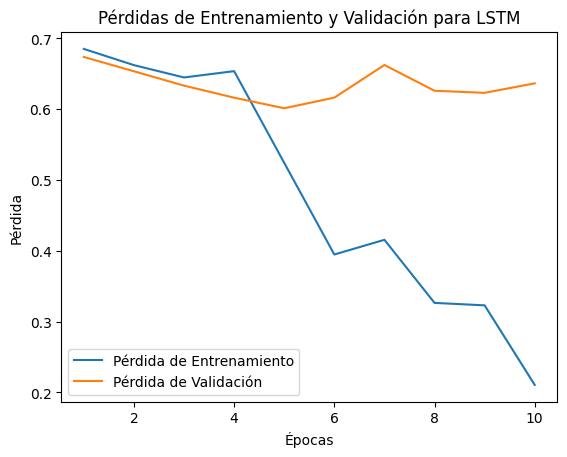

In [37]:
print("Inicio del entrenamiento de LSTM: \n")
lstm_train_perdidas, lstm_val_perdidas, lstm_val_accs = entrenamineto_y_validacion(lstm_modelo, lstm_optimizador, func_perdida, train_loader, val_loader, epochs, device)
dibujar_perdidas("LSTM",lstm_train_perdidas, lstm_val_perdidas, epochs)


Inicio del entrenamiento de RNN: 

Epoch: 1/10, Train perdida: 0.7100164095560709, Val perdida: 0.6751528382301331, Validación Acc: 0.6333333253860474
Epoch: 2/10, Train perdida: 0.6334646542867025, Val perdida: 0.6380781531333923, Validación Acc: 0.6666666865348816
Epoch: 3/10, Train perdida: 0.5537911653518677, Val perdida: 0.6194438934326172, Validación Acc: 0.6333333253860474
Epoch: 4/10, Train perdida: 0.47202009956041974, Val perdida: 0.604913055896759, Validación Acc: 0.6666666865348816
Epoch: 5/10, Train perdida: 0.43124154210090637, Val perdida: 0.600644052028656, Validación Acc: 0.6000000238418579
Epoch: 6/10, Train perdida: 0.39855754375457764, Val perdida: 0.6079150438308716, Validación Acc: 0.6333333253860474
Epoch: 7/10, Train perdida: 0.4225248595078786, Val perdida: 0.6188479065895081, Validación Acc: 0.6666666865348816
Epoch: 8/10, Train perdida: 0.2997371604045232, Val perdida: 0.6129810810089111, Validación Acc: 0.6666666865348816
Epoch: 9/10, Train perdida: 0.218594

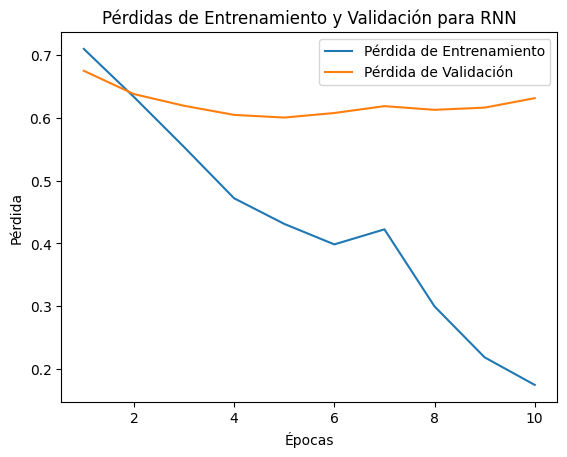

In [38]:
print("Inicio del entrenamiento de RNN: \n")
rnn_train_perdidas, rnn_val_perdidas, rnn_val_accs = entrenamineto_y_validacion(rnn_modelo, rnn_optimizador, func_perdida, train_loader, val_loader, epochs, device)
dibujar_perdidas("RNN",rnn_train_perdidas, rnn_val_perdidas, epochs)

Inicio del entrenamiento de MLP: 

Epoch: 1/10, Train perdida: 0.8836342692375183, Val perdida: 0.5940872430801392, Validación Acc: 0.699999988079071
Epoch: 2/10, Train perdida: 0.8196837902069092, Val perdida: 0.5791839361190796, Validación Acc: 0.699999988079071
Epoch: 3/10, Train perdida: 0.5836979746818542, Val perdida: 0.5812851786613464, Validación Acc: 0.699999988079071
Epoch: 4/10, Train perdida: 0.8706114987532297, Val perdida: 0.6345986723899841, Validación Acc: 0.699999988079071
Epoch: 5/10, Train perdida: 1.2749783992767334, Val perdida: 0.6715795993804932, Validación Acc: 0.699999988079071
Epoch: 6/10, Train perdida: 1.020149290561676, Val perdida: 0.6982198357582092, Validación Acc: 0.699999988079071
Epoch: 7/10, Train perdida: 0.7028371294339498, Val perdida: 0.6867469549179077, Validación Acc: 0.699999988079071
Epoch: 8/10, Train perdida: 0.5633784532546997, Val perdida: 0.7157605290412903, Validación Acc: 0.699999988079071
Epoch: 9/10, Train perdida: 0.6591843217611313

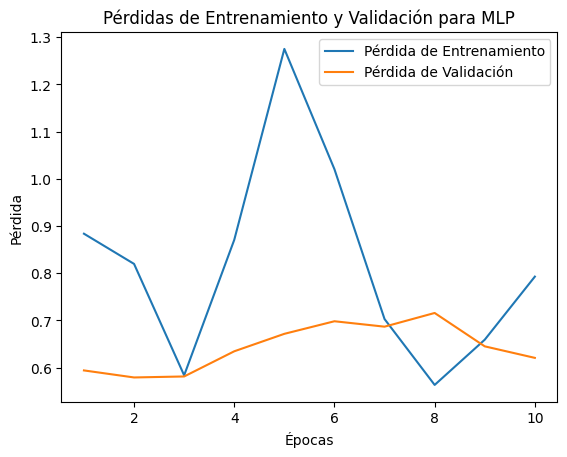

In [39]:
print("Inicio del entrenamiento de MLP: \n")
mlp_train_perdidas, mlp_val_perdidas, mlp_val_accs = entrenamineto_y_validacion(mlp_modelo, mlp_optimizador, func_perdida, train_loader, val_loader, epochs, device)
dibujar_perdidas("MLP",mlp_train_perdidas, mlp_val_perdidas, epochs)


--------- LSTM ---------

Puntuación de precisión: 0.7000
              precision    recall  f1-score   support

        Spam       0.73      0.90      0.81        21
         Ham       0.50      0.22      0.31         9

    accuracy                           0.70        30
   macro avg       0.62      0.56      0.56        30
weighted avg       0.66      0.70      0.66        30



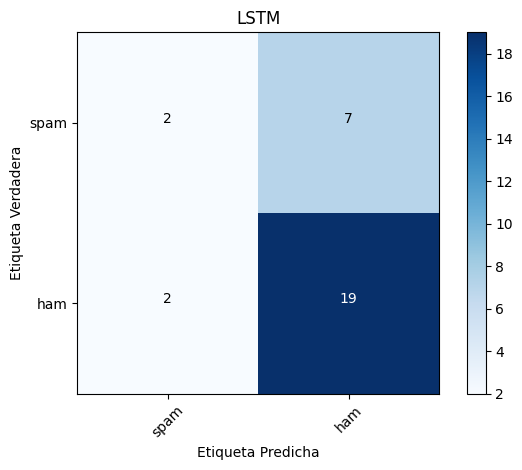

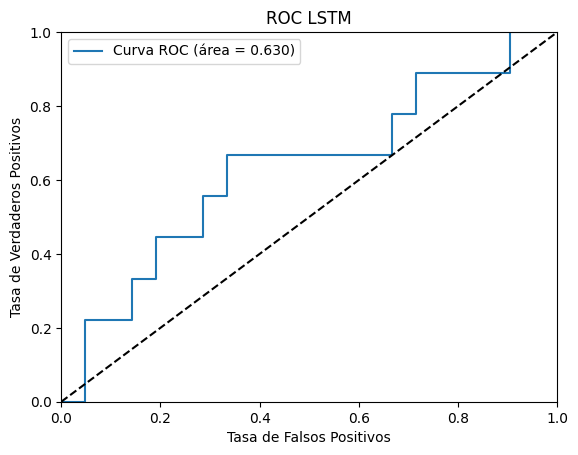

In [40]:
# Evaluar todos los modelos
resultados = []

# Modelo LSTM
lstm_puntuacion, lstm_nombre = evaluar_modelo(lstm_modelo, val_loader, device)
resultados.append((lstm_nombre, lstm_puntuacion))


--------- RNN ---------

Puntuación de precisión: 0.6667
              precision    recall  f1-score   support

        Spam       0.72      0.86      0.78        21
         Ham       0.40      0.22      0.29         9

    accuracy                           0.67        30
   macro avg       0.56      0.54      0.53        30
weighted avg       0.62      0.67      0.63        30



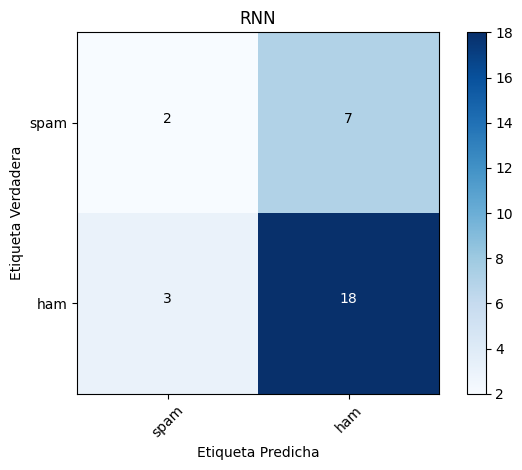

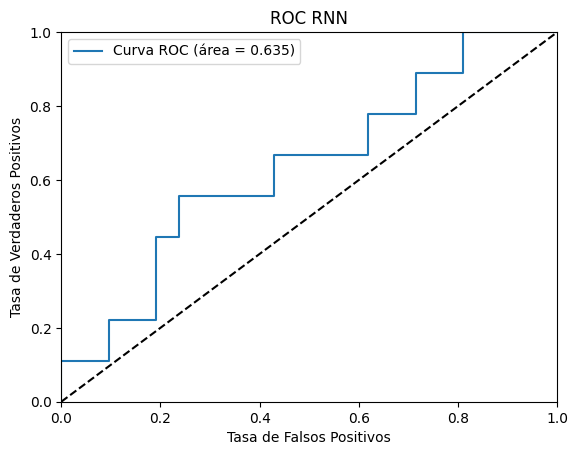

In [41]:
# Modelo RNN
rnn_puntuacion, rnn_nombre = evaluar_modelo(rnn_modelo, val_loader, device)
resultados.append((rnn_nombre, rnn_puntuacion))


--------- MLP ---------

Puntuación de precisión: 0.7000
              precision    recall  f1-score   support

        Spam       0.75      0.86      0.80        21
         Ham       0.50      0.33      0.40         9

    accuracy                           0.70        30
   macro avg       0.62      0.60      0.60        30
weighted avg       0.68      0.70      0.68        30



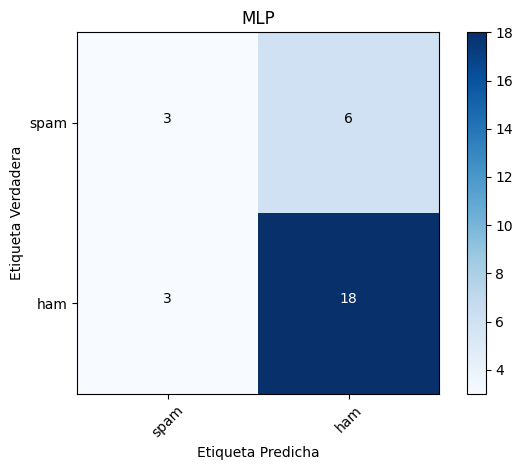

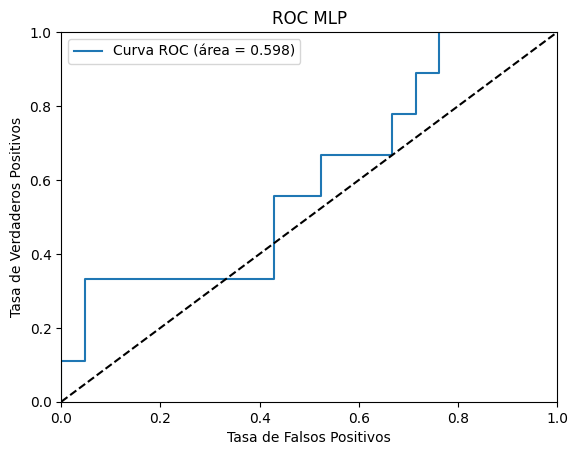

In [42]:
# Modelo RNN
mlp_puntuacion, mlp_nombre = evaluar_modelo(mlp_modelo, val_loader, device)
resultados.append((mlp_nombre, mlp_puntuacion))

In [43]:
# Imprimir resultados
for nombre, puntuacion in resultados:
    print(f'{nombre}: {puntuacion:.4f}')

LSTM: 0.7000
RNN: 0.6667
MLP: 0.7000
